# The Impact of Generative AI on Children's Creative Learning Transfer

Analysis conducted by Sachin Allums

### Loading Qualtrics Data Frame

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import time
import re
from scipy.stats import sem
import scipy.stats as stats
from scipy.stats import ttest_ind

# may need to run pip install for the given library first

In [ ]:
# note that you will need to have your own api key here!
OPEN_AI_KEY = "your-key-here"

In [3]:
data = pd.read_csv('honors_data_test.csv')
print(data.shape)

(73, 286)


In [4]:
def recode_likert_data(data):
    """
    Transforms all likert questions into numeric scales
    """
    mapping = {
        "Strongly agree": 5,
        "Somewhat agree": 4,
        "Neither agree nor disagree": 3,
        "Somewhat disagree": 2,
        "Strongly disagree": 1
    }
    
    return data.replace(mapping)

In [5]:
data = recode_likert_data(data)

In [6]:
def get_creative_self_efficacy(data):
    pre_efficacy_ids = ["Q24_2", "Q24_3", "Q24_4", "Q25_1", "Q25_3", "Q25_4"]
    post_efficacy_ids = ["Q42_3", "Q42_4", "Q42_5", "Q43_1", "Q43_3", "Q43_4"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_efficacy_ids + post_efficacy_ids] = data[pre_efficacy_ids + post_efficacy_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_efficacy_ids].notna().sum(axis=1)
    post_valid_counts = data[post_efficacy_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_efficacy_ids].sum(axis=1, skipna=True)
    post_score = data[post_efficacy_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_self_efficacy"] = pre_score_normalized
    data["post_creative_self_efficacy"] = post_score_normalized
    data["difference_creative_self_efficacy"] = post_score_normalized - pre_score_normalized
    return data

In [7]:
def get_creative_personal_identity(data):
    pre_cpi_ids = ["Q234", "Q24_1", "Q25_2", "Q25_5", "Q26_1"]
    post_cpi_ids = ["Q42_1", "Q42_2", "Q43_2", "Q43_5", "Q44_1"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_cpi_ids + post_cpi_ids] = data[pre_cpi_ids + post_cpi_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_cpi_ids].notna().sum(axis=1)
    post_valid_counts = data[post_cpi_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_cpi_ids].sum(axis=1, skipna=True)
    post_score = data[post_cpi_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_personal_identity"] = pre_score_normalized
    data["post_creative_personal_identity"] = post_score_normalized
    data["difference_creative_personal_identity"] = post_score_normalized - pre_score_normalized
    return data

In [8]:
data = get_creative_self_efficacy(data)
data = get_creative_personal_identity(data)

In [9]:
def prepend_first_AUT_to_embedded_data(df):
    """
    Prepends the Q23 string to AlternateUsesTask1 with a semicolon,
    updating the AlternateUsesTask1 column in the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'Q23' and 'AlternateUsesTask1' columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with updated 'AlternateUsesTask1' column.
    """
    df['AlternateUsesTask1'] = df['Q23'].str.strip() + '; ' + df['AlternateUsesTask1'].str.strip()    
    df['AlternateUsesTask5'] = df['Q72'].str.strip() + '; ' + df['AlternateUsesTask5'].str.strip()
    
    return df

In [10]:
data = prepend_first_AUT_to_embedded_data(data)

In [11]:
def prepend_alternate_uses(row):
    if row['AssignedCondition'] in ['Assisted-First', 'Fully Assisted']:
        row['AlternateUsesTask2'] = str(row['Q80']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q202']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q210']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    else:
        row['AlternateUsesTask2'] = str(row['Q190']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q221']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q229']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    return row

In [12]:
data = data.apply(prepend_alternate_uses, axis=1)

In [13]:
def assign_dat_columns(row):
    """
    Assigns DAT1 through DAT10 columns based on the AssignedCondition.
    
    Parameters:
        row (pd.Series): A row of the DataFrame.
        
    Returns:
        pd.Series: The row with new DAT columns assigned.
    """
    if row['AssignedCondition'] in ['Control', 'Assisted-First']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q37_{i}', None)
    elif row['AssignedCondition'] in ['Fully Assisted', 'Assisted-Second']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q193_{i}', None)
    return row

In [14]:
data = data.apply(assign_dat_columns, axis=1)

In [15]:
def score_digit_span(row):
    """
    Scores the digit span task based on the highest sequence correctly recalled.

    Parameters:
        row (pd.Series): A row of the DataFrame containing participant responses.

    Returns:
        int: The highest digit span score achieved by the participant.
    """
    # Define the correct sequences with their corresponding scores
    correct_sequences = {
        'Q141': '1376',
        'Q143': '95408',
        'Q145': '597832',
        'Q153': '4012683',
        'Q163': '83976574'
    }
    
    # Initialize the score
    score = 0
    
    # Iterate over the correct sequences
    for question, correct_answer in correct_sequences.items():
        # Check if the participant's response matches the correct answer
        if str(row.get(question, '')).strip() == correct_answer:
            # Update the score to the length of the correct sequence
            score = len(correct_answer)
    
    return score

In [16]:
digit_span_scores = data.apply(score_digit_span, axis=1)
data = pd.concat([data, digit_span_scores.rename('DigitSpanScore')], axis=1)

In [17]:
def calculate_fluency_scores(df):
    """
    Calculates fluency scores for AlternateUsesTask columns by counting semicolons.

    Parameters:
        df (pd.DataFrame): DataFrame containing AlternateUsesTask1 to AlternateUsesTask5 columns.

    Returns:
        pd.DataFrame: DataFrame with new fluency columns for each AlternateUsesTask column.
    """
    fluency_frames = {}  # Dictionary to hold new fluency columns
    

    for i in range(1, 6):
        col_name = f'AlternateUsesTask{i}'
        fluency_col_name = f'Fluency{i}'
        fluency_frames[fluency_col_name] = np.where(df[col_name].notna(), df[col_name].str.count(';') + 1, 0)

    # Create a DataFrame from the dictionary and concatenate it with the original DataFrame
    fluency_df = pd.DataFrame(fluency_frames, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df

In [18]:
def calculate_fluency_item_scores(df):
    """
    Calculates fluency scores for each object's use column by counting semicolons.
    Entries like NaN, empty strings, or 'nan; nan' are treated as zero.
    """
    items = ['shoe', 'pants', 'tire', 'bottle', 'table']
    fluency_scores = {}

    for item in items:
        col_name = f'{item}Uses'
        fluency_col_name = f'{item}Fluency'
        
        # Fill NaN and filter invalid entries like 'nan; nan'
        clean_series = df[col_name].fillna('').str.strip()
        valid_entries = (
            (clean_series != '') &
            ~clean_series.str.lower().str.fullmatch(r'(nan\s*;?\s*)+')
        )

        # Compute fluency
        fluency_scores[fluency_col_name] = np.where(
            valid_entries,
            clean_series.str.count(';') + 1,
            0
        )

    fluency_df = pd.DataFrame(fluency_scores, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df


In [88]:
# Step 1: Define the cutoff date and time
cutoff_datetime = pd.to_datetime('2025-02-17 17:00:00')

# Step 2: Have a default for any errors
default_date = pd.Timestamp('2025-01-01')
data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)

# Step 3: Filter the DataFrame
data = data[data['StartDate'] >= cutoff_datetime]
data = data[~data['Gender'].isin(['test', 'Test'])]

data = data[data['Status'] != 'Survey Preview']

# List of AUT columns to check
crucial_columns = [
    'AlternateUsesTask1',
    'AlternateUsesTask2',
    'AlternateUsesTask3',
    'AlternateUsesTask4',
    'AlternateUsesTask5',
    'Q44_2',
    'Q44_3'
]

# First replace empty strings with NaN
data[crucial_columns] = data[crucial_columns].replace('', np.nan)

# Then drop rows where any of those columns are NaN
data = data.dropna(subset=crucial_columns)


print(data['Gender'])
print(data.shape)

45                         Male
54                         Male
62                       Female
64                       Female
66                       Female
67            Prefer not to say
68                         Male
69                       Female
70    Non-binary / third gender
71                       Female
Name: Gender, dtype: object
(10, 385)


## Divergent Association Test Model
Setting up the analysis model could take a while! Give it up to 25 seconds or so

In [20]:
import dat
#This code imports the model used to quickly analyze the divergent association test: this could take up to 20 seconds!

# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("glove.840B.300d.txt", "words.txt")

In [21]:
# Combine DAT columns into lists per row
dat_cols = [f'DAT{i}' for i in range(1, 11)]

# Make sure all words are strings and handle missing values
data[dat_cols] = data[dat_cols].astype(str).fillna('')

# Apply the DAT model to each row
def compute_dat_score(row):
    words = [word for word in row[dat_cols] if word]  # Filter out empty strings
    return model.dat(words)

data['DATScore'] = data.apply(compute_dat_score, axis=1)

In [22]:
# Recoding any Assisted Fully conditions to be Fully Assisted for consistency in data analysis
data['AssignedCondition'] = data['AssignedCondition'].replace("Assisted Fully", "Fully Assisted")

## Perceptions in AI Data Visualizations
Changes in one's perception of whether AI can be useful in the creative process or whether it is more creative than a child

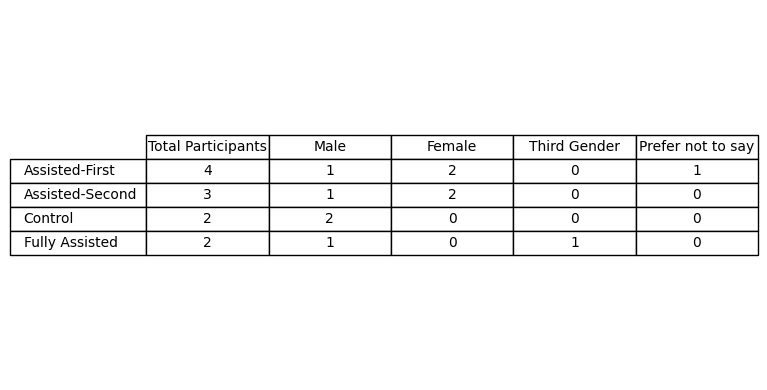

In [23]:
# Group by 'AssignedCondition' and 'Gender' to get counts
gender_distribution = data.groupby(['AssignedCondition', 'Gender']).size().unstack(fill_value=0)

# Add total count of participants in each condition
participant_count = data.groupby('AssignedCondition').size()

# Combine the gender distribution with the total count
result_table = pd.concat([participant_count, gender_distribution], axis=1)
result_table.columns = ['Total Participants', 'Male', 'Female', 'Third Gender', 'Prefer not to say']  # Adjust based on gender column

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size based on your data

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(
    cellText=result_table.values,
    colLabels=result_table.columns,
    rowLabels=result_table.index,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scale width and height of cells

# Save the table as a PNG
plt.tight_layout()
plt.savefig("plot-images/participant_gender_table.png", dpi=300, bbox_inches="tight")
plt.show()



In [24]:
# Set up styling
sns.set(style="whitegrid")

# Group by condition and compute mean
mean_scores = data.groupby("AssignedCondition")[["Q44_2", "Q44_3"]].mean().reset_index()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2992154477.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2992154477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2992154477.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2992154477.py:1

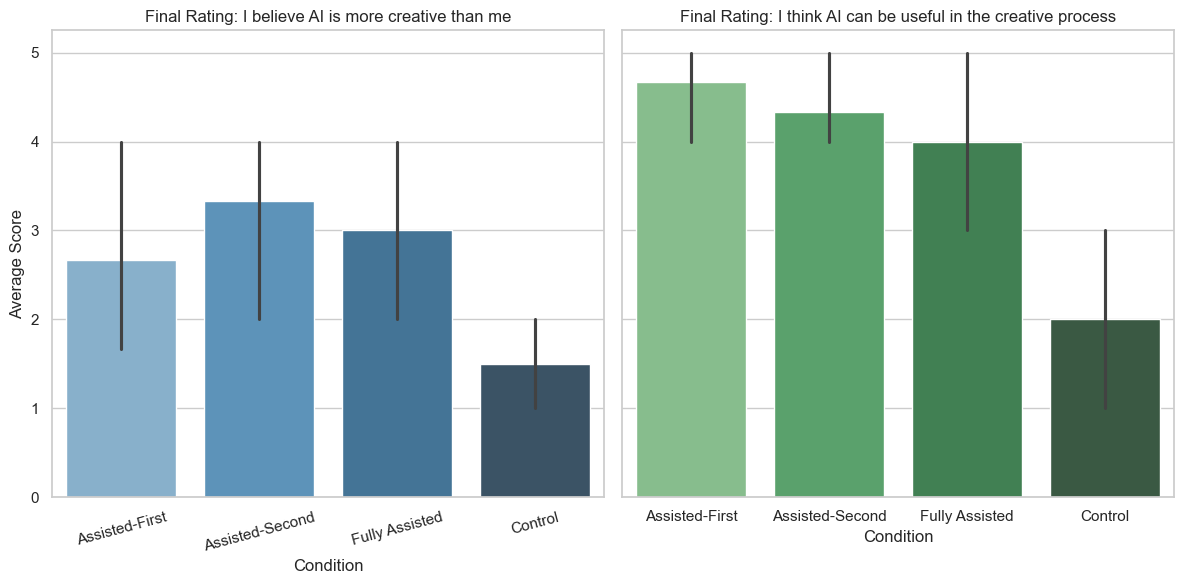

In [89]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q44_2 Bar Chart: "I believe AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Final Rating: I believe AI is more creative than me")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=15)

# Q44_3 Bar Chart: "I think AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Final Rating: I think AI can be useful in the creative process")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("plot-images/ai_perception_final_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

In [90]:
# Perform ANOVA for Q44_2 (I believe AI is more creative than me)
anova_result_q44_2 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["Q44_2"],
    data[data["AssignedCondition"] == "Fully Assisted"]["Q44_2"],
    data[data["AssignedCondition"] == "Assisted-First"]["Q44_2"],
    data[data["AssignedCondition"] == "Assisted-Second"]["Q44_2"]
)

print("ANOVA for 'I believe AI is more creative than me':")
print(anova_result_q44_2)

# Perform ANOVA for Q44_3 (I think AI can be useful in the creative process)
anova_result_q44_3 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["Q44_3"],
    data[data["AssignedCondition"] == "Fully Assisted"]["Q44_3"],
    data[data["AssignedCondition"] == "Assisted-First"]["Q44_3"],
    data[data["AssignedCondition"] == "Assisted-Second"]["Q44_3"]
    # Add more conditions as needed
)

print("\nANOVA for 'I think AI can be useful in the creative process':")
print(anova_result_q44_3)


ANOVA for 'I believe AI is more creative than me':
F_onewayResult(statistic=0.8677966101694917, pvalue=np.float64(0.5076115933952214))

ANOVA for 'I think AI can be useful in the creative process':
F_onewayResult(statistic=3.587499999999999, pvalue=np.float64(0.08571049832954525))


In [26]:
data['Delta_Q2'] = data['Q44_2'] - data['Q26_2']
data['Delta_Q3'] = data['Q44_3'] - data['Q26_3']

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2325610842.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2325610842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2325610842.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/2

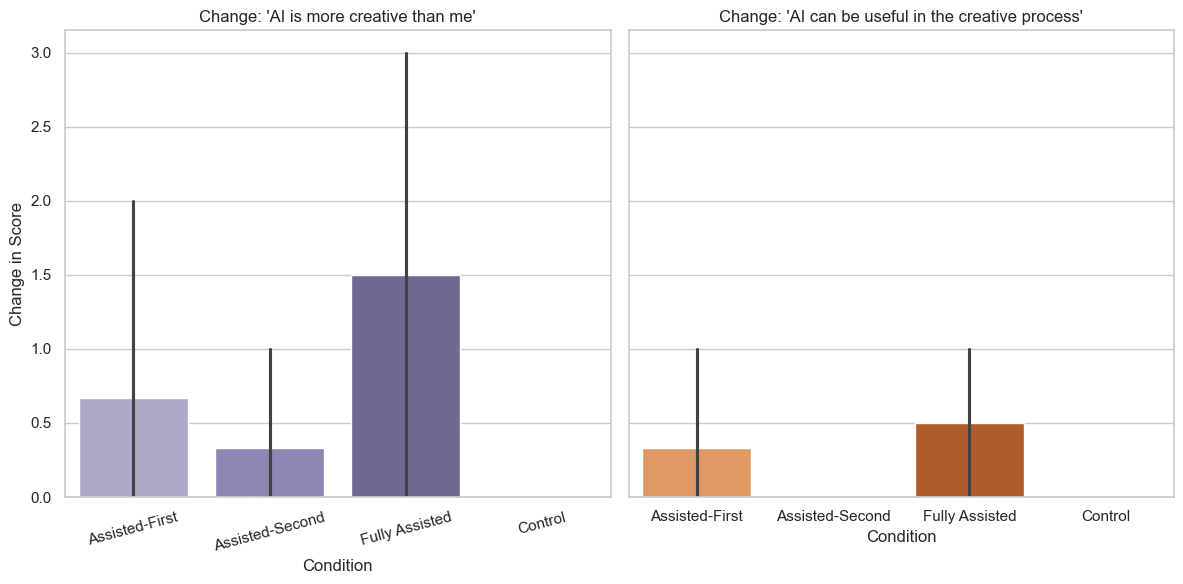

In [27]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change: 'AI is more creative than me'")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change: 'AI can be useful in the creative process'")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/ai_perception_changes.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/4287010169.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/4287010169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)


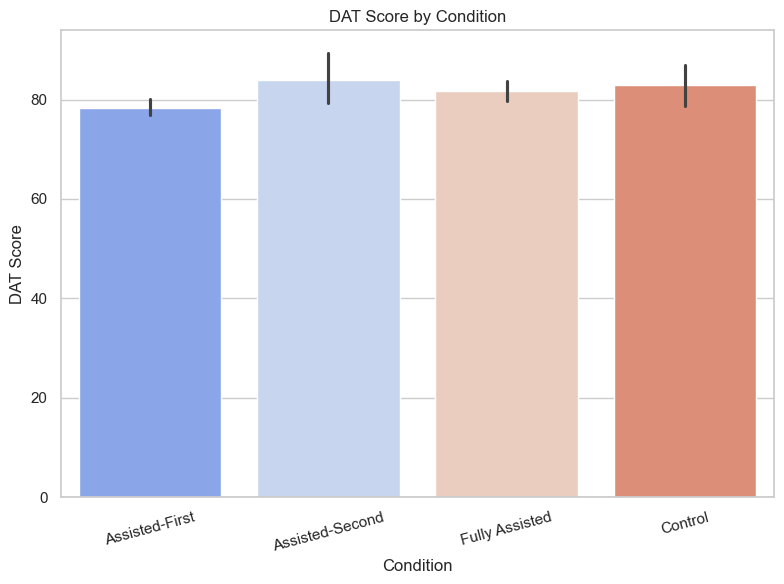

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
plt.title("DAT Score by Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()


In [91]:
# Perform ANOVA for DAT
anova_result_q44_2 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["DATScore"],
    data[data["AssignedCondition"] == "Fully Assisted"]["DATScore"],
    data[data["AssignedCondition"] == "Assisted-First"]["DATScore"],
    data[data["AssignedCondition"] == "Assisted-Second"]["DATScore"]
)

print("ANOVA for DAT score:")
print(anova_result_q44_2)

ANOVA for DAT score:
F_onewayResult(statistic=np.float32(0.80448914), pvalue=np.float32(0.5355073))


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/1817108798.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/1817108798.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)


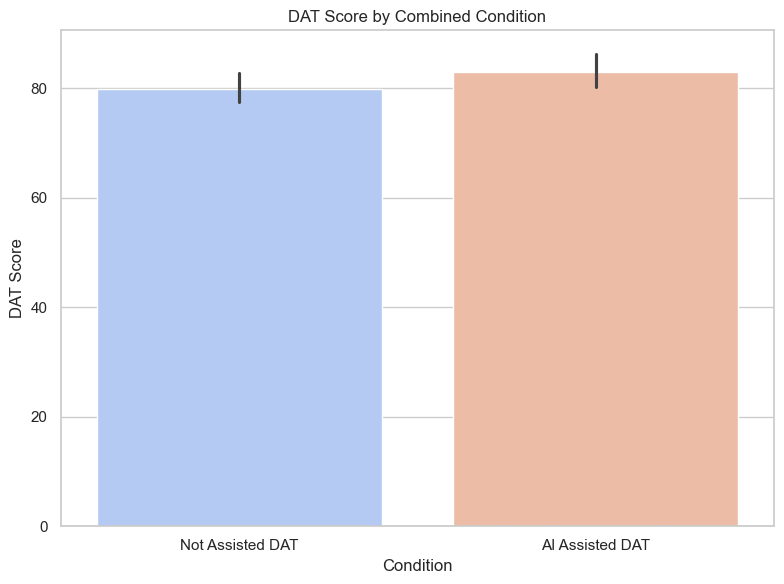

In [29]:
# Create a new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

# Plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)

plt.title("DAT Score by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
# plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Save the figure
import os
os.makedirs("plot-images", exist_ok=True)
plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_binary_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [95]:
# Create a new combined condition column
data['DATCombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

# Filter data into two groups based on 'CombinedCondition'
ai_assisted_dat = data[data['DATCombinedCondition'] == 'AI Assisted DAT']['DATScore']
not_assisted_dat = data[data['DATCombinedCondition'] == 'Not Assisted DAT']['DATScore']

print("AI Assisted DAT group size:", ai_assisted_dat.shape)
print("Not Assisted DAT group size:", not_assisted_dat.shape)


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_dat.dropna(), not_assisted_dat.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

AI Assisted DAT group size: (5,)
Not Assisted DAT group size: (5,)
T-test result: t-statistic = 1.014, p-value = 0.340


## Fluency Calculation and Visualization

In [30]:
data = calculate_fluency_scores(data)

In [31]:
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']
data['FluencyAverage'] = data[fluency_cols].mean(axis=1)

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/3185752355.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/3185752355.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)


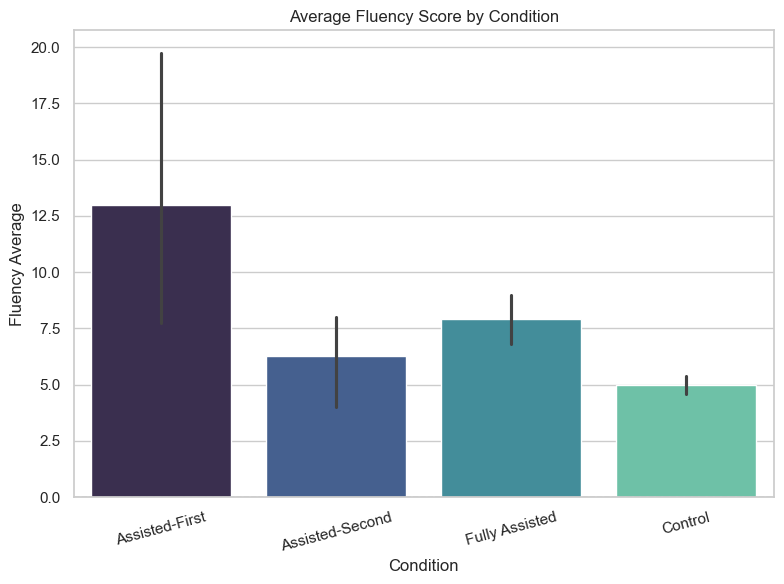

In [32]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
plt.title("Average Fluency Score by Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Average")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/fluency_average_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/298143314.py:21: SyntaxWarning: invalid escape sequence '\d'
  df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/298143314.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


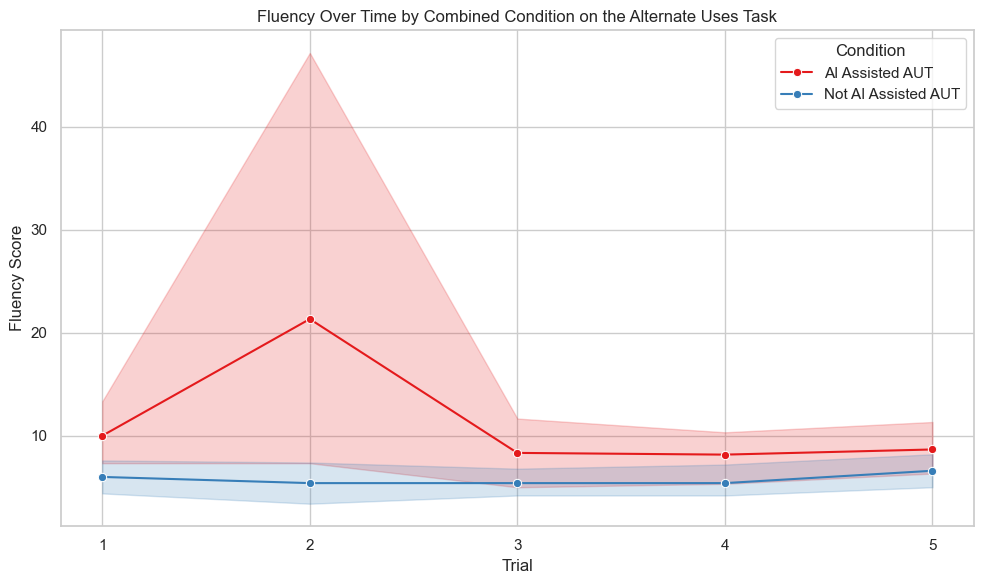

In [33]:
# Define fluency columns
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']

# Create new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Control': 'Not AI Assisted AUT',
    'Assisted-Second': 'Not AI Assisted AUT',
    'Assisted-First': 'AI Assisted AUT',
    'Fully Assisted': 'AI Assisted AUT'
})

# Melt the DataFrame to long format
df_long = data.melt(
    id_vars='CombinedCondition',
    value_vars=fluency_cols,
    var_name='Trial',
    value_name='Fluency'
)

# Extract the trial number (1–5)
df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="Trial",
    y="Fluency",
    hue="CombinedCondition",
    marker="o",
    ci=95,
    palette="Set1"
)

plt.title("Fluency Over Time by Combined Condition on the Alternate Uses Task")
plt.xlabel("Trial")
plt.ylabel("Fluency Score")
plt.xticks(ticks=range(1, 6))
plt.legend(title="Condition")
plt.tight_layout()

# Save the plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_over_time_combined.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/1539993876.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/1539993876.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


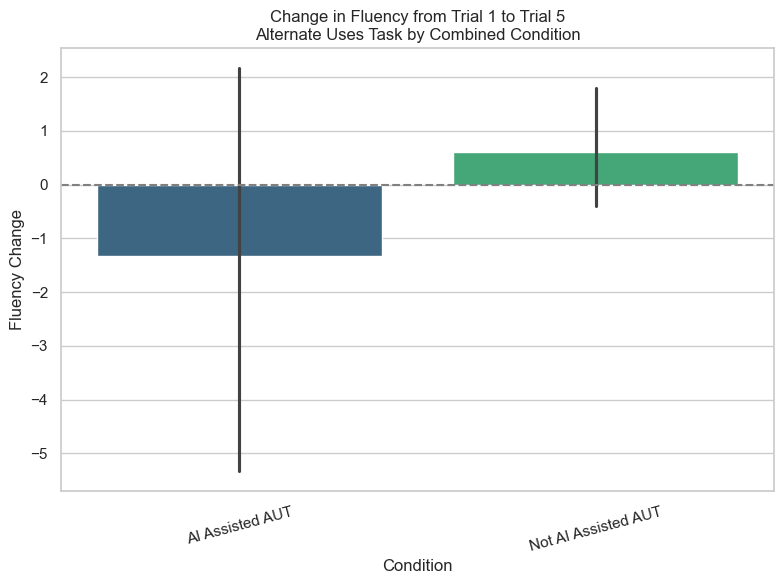

In [34]:
data['FluencyChange'] = data['Fluency5'] - data['Fluency1']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data,
    x="CombinedCondition",
    y="FluencyChange",
    palette="viridis",
    ci=95
)

plt.title("Change in Fluency from Trial 1 to Trial 5\nAlternate Uses Task by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Change")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()

# Save plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_change_combined_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [97]:
# Create a new combined condition column
# Create new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Control': 'Not AI Assisted AUT',
    'Assisted-Second': 'Not AI Assisted AUT',
    'Assisted-First': 'AI Assisted AUT',
    'Fully Assisted': 'AI Assisted AUT'
})

# Filter data into two groups based on 'CombinedCondition'
ai_assisted_aut = data[data['CombinedCondition'] == 'AI Assisted AUT']['FluencyChange']
not_assisted_aut = data[data['CombinedCondition'] == 'Not AI Assisted AUT']['FluencyChange']

print("AI Assisted AUT group size:", ai_assisted_aut.shape)
print("Not Assisted AUT group size:", not_assisted_aut.shape)


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut.dropna(), not_assisted_aut.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

AI Assisted AUT group size: (5,)
Not Assisted AUT group size: (5,)
T-test result: t-statistic = -0.243, p-value = 0.814


## Originality Scores

In [35]:
# Initialize new columns
data['tableUses'] = ""
data['tireUses'] = ""
data['bottleUses'] = ""
data['pantsUses'] = ""
data['shoeUses'] = ""

# Iterate through rows
for idx, row in data.iterrows():
    for i in range(1, 6):
        item = str(row[f'Item{i}']).strip().lower()
        use = row[f'AlternateUsesTask{i}']
        
        if item == "table":
            data.at[idx, 'tableUses'] = use
        elif item == "tire":
            data.at[idx, 'tireUses'] = use
        elif item == "bottle":
            data.at[idx, 'bottleUses'] = use
        elif item in ["pair of pants", "pants"]:
            data.at[idx, 'pantsUses'] = use
        elif item == "shoe":
            data.at[idx, 'shoeUses'] = use


item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
item_columns = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5']
uses_columns = ['AlternateUsesTask1', 'AlternateUsesTask2', 'AlternateUsesTask3', 'AlternateUsesTask4', 'AlternateUsesTask5']

In [36]:
def extract_ratings_list(response):
    if not response:
        return []
    ratings = re.findall(r"\b(10|[1-9])\b", response)
    return [int(r) for r in ratings]

In [37]:
def call_openai_gpt(prompt):
    client = openai.OpenAI(api_key=OPEN_AI_KEY)
    response = client.responses.create(
        model="gpt-4o",
        input = prompt
    )
    print(response.output_text)
    return response.output_text

In [38]:
item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
all_item_uses = {}

# Step 1: Aggregate all uses for each item
for item in item_names:
    all_uses = []

    for idx, row in data.iterrows():
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    all_uses.extend(split_uses)

    # Optional: remove duplicates
    unique_uses = list(set(all_uses))
    all_item_uses[item] = unique_uses


In [39]:
def build_prompt(item, uses):
    prompt = f"Below is a list of uses for a {item}. On a scale of 1–10, judge how original each use for a {item} is, where 1 is 'not at all creative' and 10 is 'very creative'.\n\n"
    for idx, use in enumerate(uses, 1):
        prompt += f"{idx}. {use}\n"
    return prompt


#### The following runs GPT 4o here - be careful when running since it does charge a couple of cents per run!

In [40]:
item_scores = {}
item_raw_responses = {}

# uncomment the following lines in order to run GPT to evaluate all of the different uses! Comment after you're done
# Step 3: Call GPT once per item
for item, uses in all_item_uses.items():
    prompt = build_prompt(item, uses)
    response = call_openai_gpt(prompt)  # <-- Your API call here
    item_raw_responses[item] = response

    scores = extract_ratings_list(response)
    item_scores[item] = dict(zip(uses, scores))

Here's a rating for each use:

1. decoration - 3
2. stand on - 3
3. tool - 2
4. stool - 5
5. foot rest - 4
6. spare wood - 5
7. play games on - 4
8. use it as a bed - 5
9. hide under - 4
10. You can use it as a table - 1
11. As a stool - 4
12. to eat a meal - 1
13. sisy - 1 (unclear)
14. sit on - 3
15. workout assistant - 4
16. Use the legs to make a rake - 7
17. write/draw on - 4
18. scare someone from underneath - 6
19. a chair - 2
20. free wood - 5
21. chair - 2
22. a rotating disk to use as a spare tire - 8
23. use it as an umbrella - 7
24. paint - 3
25. use it as a wooden helmet - 8
26. use as surface for art - 4
27. use as cooking surface - 4
28. table legs for repurpose - 6
29. stand on top of to get higher - 3
30. let lumberjacks be happier - 2
31. making things out of wood - 3
32. john - 1 (unclear)
33. cut up - 3
34. throw at someone - 6
35. a ceiling fan that kind of works i guess - 7
36. frame for enclosure - 6
37. block a door - 5
38. legs as baseball bats - 7
39. Chair - 

In [41]:
for item in item_names:
    creativity_ratings = []

    for idx, row in data.iterrows():
        participant_uses = []
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    participant_uses.extend(split_uses)

        if participant_uses:
            # Use pre-scored values
            scores = [item_scores[item].get(use, None) for use in participant_uses]
            avg_score = sum(s for s in scores if s is not None) / len(scores) if scores else None
        else:
            avg_score = None

        creativity_ratings.append(avg_score)

    data[f"{item}CreativityRating"] = creativity_ratings


In [42]:
print(data['shoeCreativityRating'])
print(data['pair of pantsCreativityRating'])
print(data['tableCreativityRating'])
print(data['bottleCreativityRating'])
print(data['tireCreativityRating'])

45    4.750000
54    6.666667
55    4.000000
62    4.875000
64    4.000000
66    5.888889
67    4.500000
68    4.666667
69    5.750000
70    3.666667
71    4.800000
Name: shoeCreativityRating, dtype: float64
45    3.923077
54    2.500000
55    3.352941
62    4.125000
64    4.000000
66    3.875000
67    4.000000
68    5.000000
69    2.500000
70    4.833333
71    4.000000
Name: pair of pantsCreativityRating, dtype: float64
45    3.923077
54    3.600000
55    4.750000
62    4.777778
64    3.461538
66    4.142857
67    5.400000
68    4.333333
69    4.800000
70    3.750000
71    4.750000
Name: tableCreativityRating, dtype: float64
45    3.400000
54    3.000000
55    3.800000
62    3.545455
64    5.142857
66    4.250000
67    6.750000
68    2.625000
69    4.250000
70    4.142857
71    2.800000
Name: bottleCreativityRating, dtype: float64
45    5.888889
54    6.250000
55    4.000000
62    4.888889
64    6.083333
66    4.625000
67    6.166667
68    4.166667
69    3.750000
70    5.142857
71    

In [43]:
# Define a function to get the creativity rating for a specific item column
def get_creativity_rating(row, item_col):
    item = row[item_col]
    rating_col = f"{item}CreativityRating"
    return row.get(rating_col, None)

# Apply this function for Item1 to Item5
for i in range(1, 6):
    data[f"AUTOriginality{i}"] = data.apply(lambda row: get_creativity_rating(row, f"Item{i}"), axis=1)


In [44]:
print(data['AUTOriginality1'])
print(data['AUTOriginality2'])
print(data['AUTOriginality3'])
print(data['AUTOriginality4'])
print(data['AUTOriginality5'])

45    3.923077
54    6.666667
55    3.352941
62    4.777778
64    5.142857
66    4.250000
67    4.000000
68    4.666667
69    3.750000
70    3.750000
71    2.800000
Name: AUTOriginality1, dtype: float64
45    5.888889
54    3.600000
55    3.800000
62    4.888889
64    6.083333
66    4.625000
67    6.166667
68    2.625000
69    2.500000
70    5.142857
71    5.500000
Name: AUTOriginality2, dtype: float64
45    3.400000
54    2.500000
55    4.000000
62    3.545455
64    4.000000
66    3.875000
67    5.400000
68    4.166667
69    4.800000
70    4.833333
71    4.750000
Name: AUTOriginality3, dtype: float64
45    4.750000
54    6.250000
55    4.000000
62    4.125000
64    4.000000
66    5.888889
67    4.500000
68    5.000000
69    5.750000
70    4.142857
71    4.800000
Name: AUTOriginality4, dtype: float64
45    3.923077
54    3.000000
55    4.750000
62    4.875000
64    3.461538
66    4.142857
67    6.750000
68    4.333333
69    4.250000
70    3.666667
71    4.000000
Name: AUTOriginality5, 

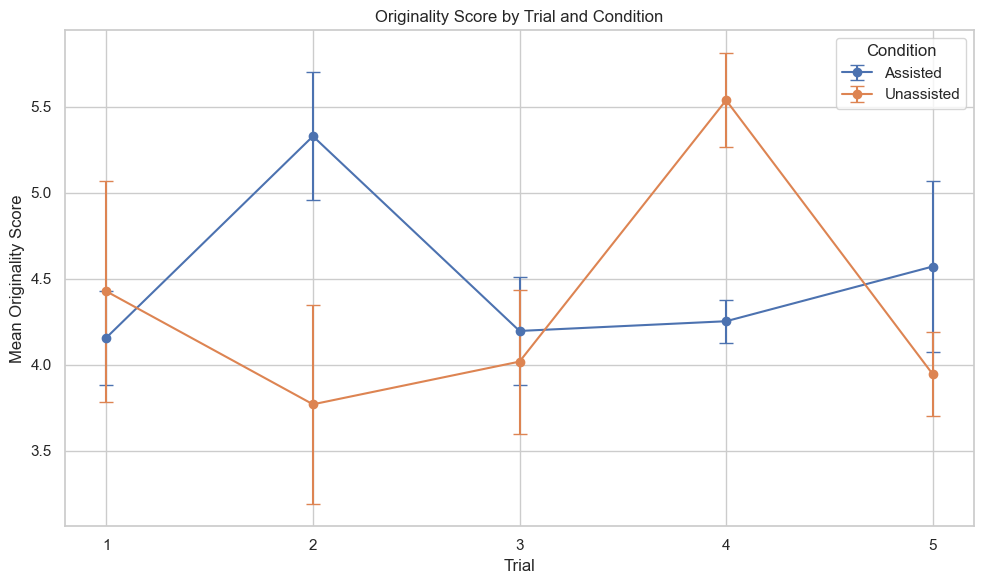

In [45]:
# First, define the mapping
def map_combined_condition(cond):
    if cond in ['Assisted-First', 'Fully Assisted']:
        return 'Assisted'
    else:
        return 'Unassisted'

# Apply the mapping
data['CombinedCondition'] = data['AssignedCondition'].map(map_combined_condition)

# Melt the data to long format for easier plotting
melted = data.melt(
    id_vars='CombinedCondition',
    value_vars=[f'AUTOriginality{i}' for i in range(1, 6)],
    var_name='Trial',
    value_name='OriginalityScore'
)

# Aggregate: compute mean and standard error
summary = (
    melted
    .groupby(['CombinedCondition', 'Trial'])
    .agg(mean_score=('OriginalityScore', 'mean'),
         sem_score=('OriginalityScore', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# Convert 'AUTOriginality1' to 1, 'AUTOriginality2' to 2, etc.
summary['Trial'] = summary['Trial'].str.extract(r'(\d)').astype(int)

# Plot
plt.figure(figsize=(10, 6))
for condition in summary['CombinedCondition'].unique():
    subset = summary[summary['CombinedCondition'] == condition]
    plt.errorbar(
        subset['Trial'],
        subset['mean_score'],
        yerr=subset['sem_score'],
        label=condition,
        marker='o',
        capsize=5
    )

plt.title('Originality Score by Trial and Condition')
plt.xlabel('Trial')
plt.ylabel('Mean Originality Score')
plt.xticks([1, 2, 3, 4, 5])  # Set custom x-axis ticks
plt.legend(title='Condition')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot-images/originality_aut_over_time_combined_condition.png", dpi=300, bbox_inches='tight')
plt.show()


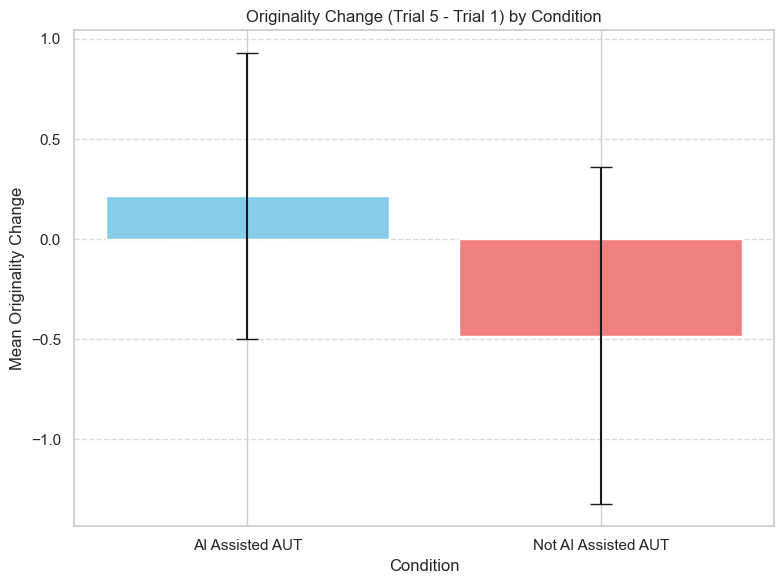

In [99]:
# Calculate the change from Trial 1 to Trial 5
data["OriginalityChange"] = data["AUTOriginality5"] - data["AUTOriginality1"]

# Group and summarize
change_summary = (
    data.groupby("CombinedCondition")["OriginalityChange"]
    .agg(mean_change='mean', sem_change=lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(
    change_summary['CombinedCondition'],
    change_summary['mean_change'],
    yerr=change_summary['sem_change'],
    capsize=8,
    color=['skyblue', 'lightcoral']
)

plt.title("Originality Change (Trial 5 - Trial 1) by Condition")
plt.ylabel("Mean Originality Change")
plt.xlabel("Condition")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/originality_change_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ai_assisted_aut = data[data['CombinedCondition'] == 'AI Assisted AUT']['OriginalityChange']
not_assisted_aut = data[data['CombinedCondition'] == 'Not AI Assisted AUT']['OriginalityChange']

# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut.dropna(), not_assisted_aut.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

T-test result: t-statistic = 0.634, p-value = 0.544


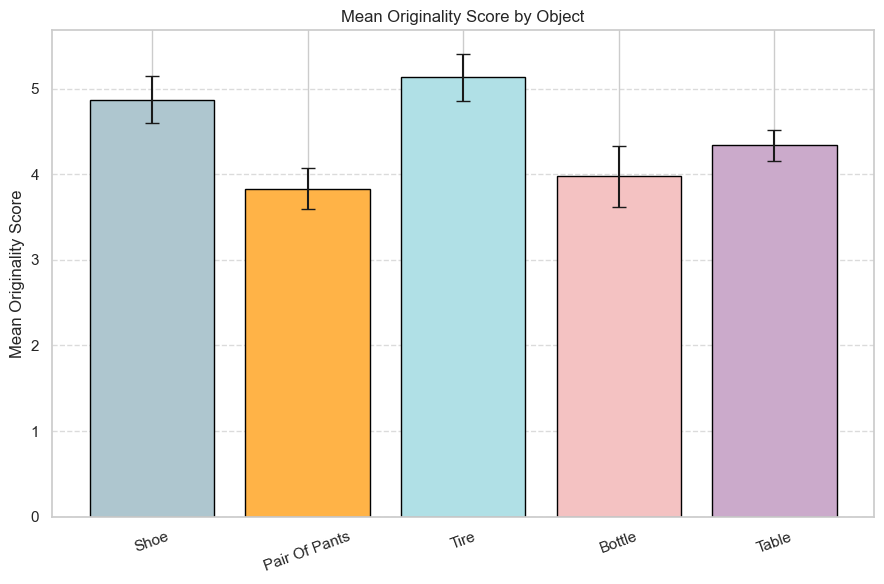

In [46]:
# Define pastel colors (manually selected or from seaborn palette)
pastel_colors = ['#aec6cf', '#ffb347', '#b0e0e6', '#f4c2c2', '#cbaacb']

# List of the creativity rating columns
creativity_columns = [
    'shoeCreativityRating',
    'pair of pantsCreativityRating',
    'tireCreativityRating',
    'bottleCreativityRating',
    'tableCreativityRating'
]

# Calculate means and SEMs
mean_scores = data[creativity_columns].mean()
sem_scores = data[creativity_columns].apply(sem, nan_policy='omit')

# Clean up the labels for display
labels = [col.replace('CreativityRating', '').title() for col in creativity_columns]

# Plot
plt.figure(figsize=(9, 6))
bars = plt.bar(labels, mean_scores, yerr=sem_scores, capsize=5,
               color=pastel_colors, edgecolor='black')

plt.ylabel('Mean Originality Score')
plt.title('Mean Originality Score by Object')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/originality_per_object.png", dpi=300, bbox_inches='tight')
plt.show()

## Flexibility Rating and Visualization

#### Run the following for flexibility ratings: it does cost some money!

In [47]:
def get_categories(item, responses):
    prompt = (
        f"In a recent study, students were given the AUT test for the following object: {item}.\n"
        f"The following responses were given: {responses}.\n"
        "Please examine the responses and determine the distinct categories into which you would assign the responses.\n"
        "Output only the category names. I would like the number of categories to be between 15 and 20.\n"
        "Return the list of categories, one per line. Do not include numbering, quotes, or examples—only the name of each category."
    )
    return prompt


def assign_categories(item, responses, categories):
    """
    Prepares a GPT prompt to categorize responses for multiple participants while keeping them separable.
    Ensures each participant block is clearly delimited to prevent merging.
    """
    all_prompts = ""

    for idx, response_str in enumerate(responses):
        individual_uses = [use.strip() for use in response_str.split(';') if use.strip()]

        if not individual_uses or not is_valid_response(response_str):
            prompt = (
                f"### Participant {idx+1}:\n"
                f"No responses were given for the object: {item}.\n"
                f"Output ONLY the phrase: NO RESPONSE.\n\n"
                f"(Separate each participant's output with TWO newlines.)\n"
            )
        else:
            uses_text = "\n".join(f"{i+1}. {use}" for i, use in enumerate(individual_uses))
            prompt = (
                f"### Participant {idx+1}:\n"
                f"Object: {item}\n"
                f"Responses:\n{uses_text}\n\n"
                f"Assign ONE category from the list below to EACH response:\n{categories}\n\n"
                f"Respond with ONLY the category names, one per line, in the SAME ORDER as the responses.\n"
                f"Do NOT include any numbers, quotation marks, or repeated responses.\n"
                f"Do NOT add explanations or comments.\n"
                f"AFTER EACH PARTICIPANT'S OUTPUT, insert TWO NEWLINES to separate them.\n"
            )

        all_prompts += prompt + "\n"

    return all_prompts



def parse_flexibility_categories(gpt_output):
    """
    Parses GPT's output where each participant's set of responses was categorized line by line.
    Returns a list of flexibility scores (i.e., number of unique categories per participant),
    with 0 for participants who gave no responses.
    """
    participant_blocks = gpt_output.strip().split("\n\n")
    flexibility_scores = []

    for block in participant_blocks:
        lines = [line.strip() for line in block.split("\n") if line.strip()]
        
        if len(lines) == 1 and lines[0].upper() == "NO RESPONSE":
            flexibility_scores.append(0)
        else:
            unique_categories = set(lines)
            flexibility_scores.append(len(unique_categories))

    return flexibility_scores


def is_valid_response(response_str):
    """
    Checks if a participant's response is non-empty and doesn't consist solely of 'nan' entries.
    """
    if pd.isna(response_str) or response_str.strip() == '':
        return False
    parts = [p.strip().lower() for p in response_str.split(';')]
    return any(p not in ('', 'nan') for p in parts)



def get_batched_flexibility_scores(df, item, col_name):
    use_series = df[col_name].replace('', np.nan)  # Replace empty strings with NaN
    use_series = use_series.replace('nan; nan', np.nan)
    use_series = use_series.fillna('')
    index_list = use_series.index.tolist()
    responses = use_series.tolist()
    print('Responses: ', responses)

    # STEP 1: Get categories from GPT
    prompt = get_categories(item, responses)
    categories = call_openai_gpt(prompt)

    # STEP 2: Assign categories to each use
    new_prompt = assign_categories(item, responses, categories)
    content = call_openai_gpt(new_prompt)

    # STEP 3: Parse and count unique categories per participant
    scores = parse_flexibility_categories(content)

    # STEP 4: Align scores back to original DataFrame
    result_series = pd.Series([None] * len(df), index=df.index)
    for i, idx in enumerate(index_list):
        if i < len(scores):
            result_series.loc[idx] = scores[i]

    return result_series

In [59]:
# data['shoeFlexibility'] = get_batched_flexibility_scores(data, 'shoe', 'shoeUses')
data['pantsFlexibility'] = get_batched_flexibility_scores(data, 'pair of pants', 'pantsUses')
data['tableFlexibility'] = get_batched_flexibility_scores(data, 'table', 'tableUses')
data['bottleFlexibility'] = get_batched_flexibility_scores(data, 'bottle', 'bottleUses')
data['tireFlexibility'] = get_batched_flexibility_scores(data, 'tire', 'tireUses')


Responses:  ['You can use it as a jester hat; you can use it as a belt; A scarf; A blanket; A cusion; Warm up yourself; Blow out fires; Sheild; whip; a ruler; free string; make cows mad?; wear', "to keep you warm; to protect you from objects; use it's fabric to repair some other object that is torn; to wrap/cushion something", 'Shorts; Bandana; Hat; Socks; Bag; Stuffy; Sloth; Animals; Shoes; Needle holder; Egg holder; Phone holder; Book pages; Coins; Metal; Gold in pants; Storage', 'wear them; turn them into a skirt; turn them into shorts; turn them into a shirt; paint them; turn them into a bag; turn them into a pillow; turn them into', 'Wearing; Art; Make a patch; tote bag; pillow; jacket; skirt; shorts; rug; apron; headbands', 'Wear them; Cut them into shorts; Cut and sew them into a denim skirt; Cut them to make flair jeans; Cut them into a denim top; Sew it into a container; Cut the top part out and make sleeves; Make it into dolls clothes', 'to breathe underwater; as a belt; as a

In [72]:
data = calculate_fluency_item_scores(data)
print(data['pantsFlexibility'])

45    10
54     4
55     7
62     4
64     6
66     4
67     4
68     5
69     2
70     6
71     4
Name: pantsFlexibility, dtype: object


In [50]:
print(data['shoeUses'].tolist)

<bound method IndexOpsMixin.tolist of 45    Slipper; Whoop; Kick; Throw; Give to goat; fre...
54    to protect your foot from sharp objects; so yo...
55                                             nan; nan
62    wear them; planter diy; hang them on a tree as...
64    Outfits; shoelace for tieing things; birdhouse...
66    Wear them; Donate them; Plant a flower in them...
67    planters; drink holders; door stops; birdhouse...
68    wear it on your feet; use it to kill bugs; use...
69    storage (bottles); opener (smack the bottom of...
70    insect killer; dog toy; planter; painting; cat...
71    You can wear it on your foot; You can attach p...
Name: shoeUses, dtype: object>


#### Visualize flexibility over time

In [73]:
# Define a function to get the flexibility rating for a specific item column
def get_flexibility_rating(row, item_col):
    item = row[item_col]
    
    # Handle special cases
    item_mapping = {
        'pair of pants': 'pants'
    }
    item_key = item_mapping.get(item, item)  # Use mapped value or original

    rating_col = f"{item_key}Flexibility"
    return row.get(rating_col, None)

# Apply this function for Item1 to Item5
for i in range(1, 6):
    data[f"Flexibility{i}"] = data.apply(lambda row: get_flexibility_rating(row, f"Item{i}"), axis=1)

In [79]:
data['CombinedCondition'] = data['AssignedCondition'].map(map_combined_condition)

In [80]:
# Melt the data for flexibility
melted_flex = data.melt(
    id_vars='CombinedCondition',
    value_vars=[f'Flexibility{i}' for i in range(1, 6)],
    var_name='Trial',
    value_name='FlexibilityScore'
)

# Aggregate mean and SEM
summary_flex = (
    melted_flex
    .groupby(['CombinedCondition', 'Trial'])
    .agg(mean_score=('FlexibilityScore', 'mean'),
         sem_score=('FlexibilityScore', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# Convert 'Flexibility1' to 1, etc.
summary_flex['Trial'] = summary_flex['Trial'].str.extract(r'(\d)').astype(int)

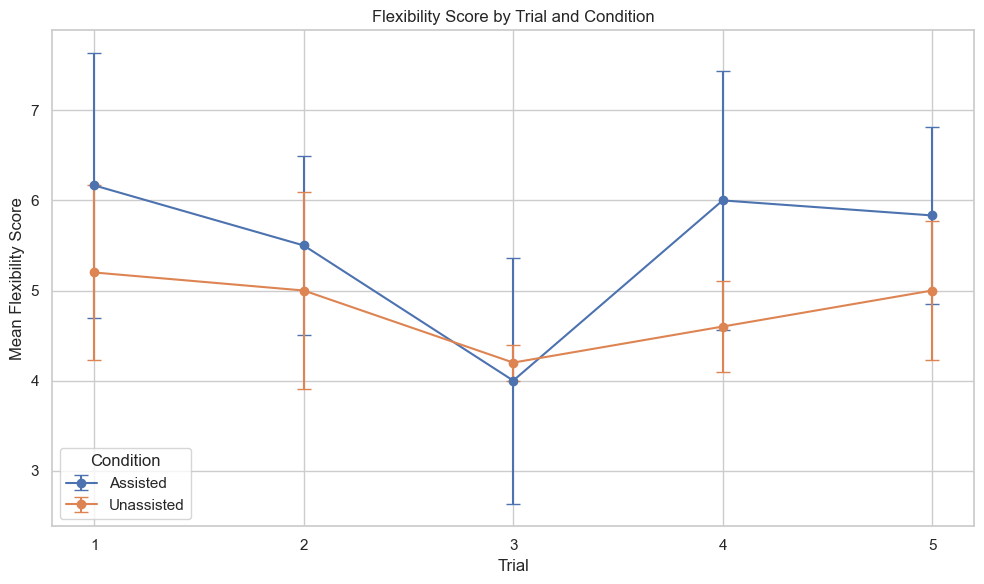

In [81]:
plt.figure(figsize=(10, 6))
for condition in summary_flex['CombinedCondition'].unique():
    subset = summary_flex[summary_flex['CombinedCondition'] == condition]
    plt.errorbar(
        subset['Trial'],
        subset['mean_score'],
        yerr=subset['sem_score'],
        label=condition,
        marker='o',
        capsize=5
    )

plt.title('Flexibility Score by Trial and Condition')
plt.xlabel('Trial')
plt.ylabel('Mean Flexibility Score')
plt.xticks([1, 2, 3, 4, 5])
plt.legend(title='Condition')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot-images/flexibility_aut_over_time_combined_condition.png", dpi=300, bbox_inches='tight')
plt.show()


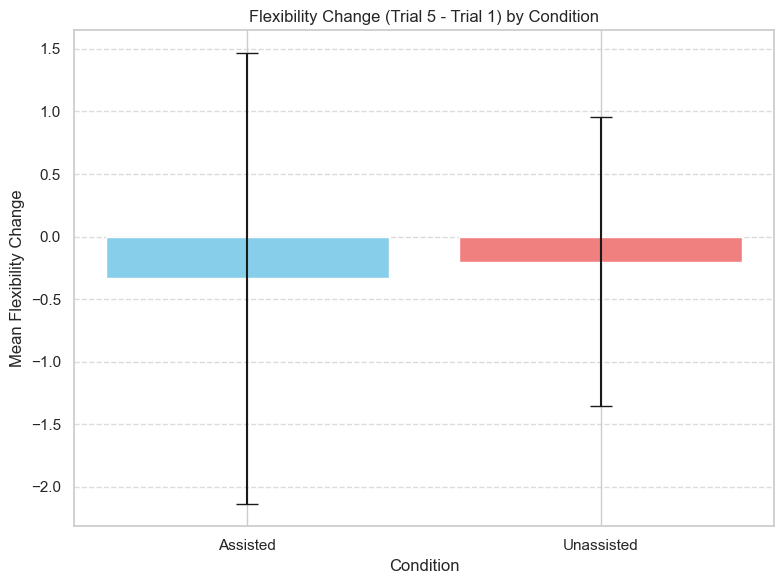

In [82]:
# Calculate the change from Trial 1 to Trial 5
data["FlexibilityChange"] = data["Flexibility5"] - data["Flexibility1"]

# Group and summarize
change_summary = (
    data.groupby("CombinedCondition")["FlexibilityChange"]
    .agg(mean_change='mean', sem_change=lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(
    change_summary['CombinedCondition'],
    change_summary['mean_change'],
    yerr=change_summary['sem_change'],
    capsize=8,
    color=['skyblue', 'lightcoral']
)

plt.title("Flexibility Change (Trial 5 - Trial 1) by Condition")
plt.ylabel("Mean Flexibility Change")
plt.xlabel("Condition")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plot-images/flexibility_change_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

In [102]:
ai_assisted_aut = data[data['CombinedCondition'] == 'AI Assisted AUT']['FlexibilityChange']
not_assisted_aut = data[data['CombinedCondition'] == 'Not AI Assisted AUT']['FlexibilityChange']


# Perform a t-test
t_stat, p_value = ttest_ind(ai_assisted_aut.dropna(), not_assisted_aut.dropna())

# Print the t-test result
print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

T-test result: t-statistic = 0.361, p-value = 0.727


## Creative Self-Efficacy and Creative Personal Identity

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/3882049024.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/3882049024.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_10729/3882049024.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="difference_creative_personal_identity", ax=axes[1], palette="Orange

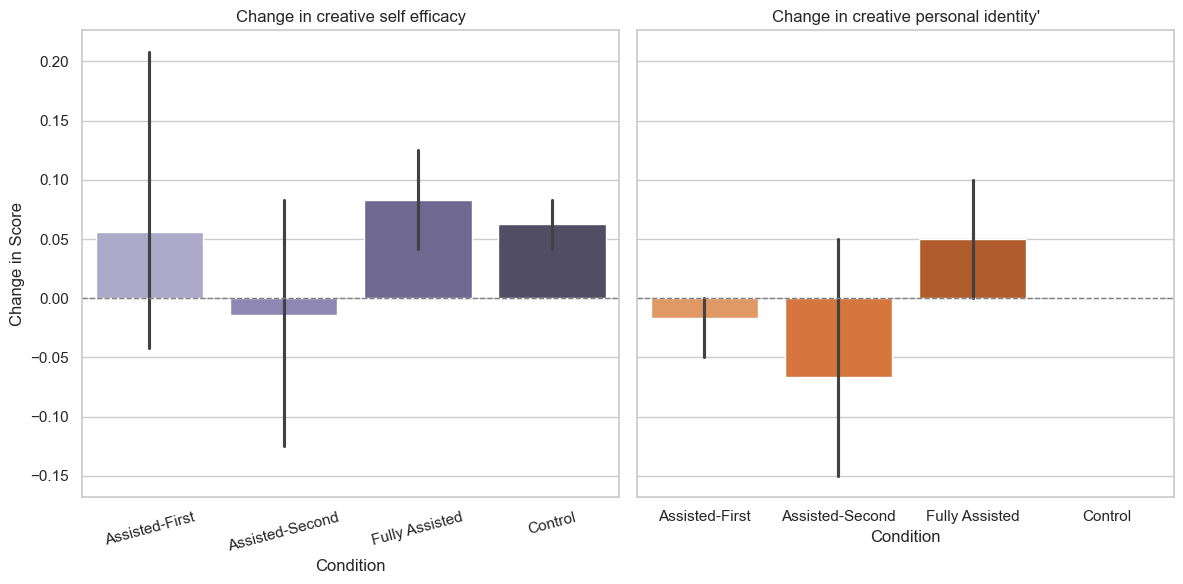

In [84]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="difference_creative_self_efficacy", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change in creative self efficacy")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="difference_creative_personal_identity", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change in creative personal identity'")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/creative_self_efficacy_and_cpi.png", dpi=300, bbox_inches='tight')
plt.show()

In [103]:
# Perform ANOVA for change in creative self efficacy
anova_result_q44_2 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Fully Assisted"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Assisted-First"]["difference_creative_self_efficacy"],
    data[data["AssignedCondition"] == "Assisted-Second"]["difference_creative_self_efficacy"]
)

print("ANOVA for difference_creative_self_efficacy:")
print(anova_result_q44_2)

# Perform ANOVA for Q44_3 (I think AI can be useful in the creative process)
anova_result_q44_3 = stats.f_oneway(
    data[data["AssignedCondition"] == "Control"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Fully Assisted"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Assisted-First"]["difference_creative_personal_identity"],
    data[data["AssignedCondition"] == "Assisted-Second"]["difference_creative_personal_identity"]
    # Add more conditions as needed
)

print("\nANOVA for difference_creative_personal_identity:")
print(anova_result_q44_3)

ANOVA for difference_creative_self_efficacy:
F_onewayResult(statistic=np.float64(0.45581395348837245), pvalue=np.float64(0.7229158570078172))

ANOVA for difference_creative_personal_identity:
F_onewayResult(statistic=np.float64(1.1941176470588222), pvalue=np.float64(0.3886888411399277))
